# MLP
This notebook is part of the waste image classification project.

Here we explore the viability of Multilayer Percetprons for waste image classification.

In [1]:
import os
import shutil
import pickle

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array, load_img)
from tensorflow.keras import callbacks, models, layers, losses

from azureml.core import Workspace, Dataset, ScriptRunConfig
from azureml.core.environment import Environment
from azureml.tensorboard import Tensorboard

from utils import log_runs, visualize_log, plot_accuracy, get_runtime

# Setup

Load in the resources created in the first notebook and setup for this set of experiments.

In [2]:
# Load the stored workspace
ws = Workspace.from_config()

In [3]:
# Get the registered dataset from azure
dataset = Dataset.get_by_name(ws, name='waste_images')

In [4]:
# get the registered env
env = Environment.get(ws, 'waste-env-gpu')

In [5]:
# get our compoute cluster
compute_name = "gpu-cluster-NC6"
compute_target = ws.compute_targets[compute_name]

In [6]:
# set the expiriment
experiment_name = 'mlp'
from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

# Write control script

The control script will be uploaded to aml instances in azure.  Images are cached in Azure, so parameterizing the script results in faster run times than submitting new scrips for each run.  It also allows for faster iteration of the models.

In [7]:
# setup a directory for to upload for the run
script_path = 'mlp_train_script/'
if not os.path.exists(script_path):
    os.mkdir(script_path)

# move the util file to the upload dir
shutil.copy('utils.py', script_path)


'mlp_train_script/utils.py'

In [8]:
%%writefile mlp_train_script/train.py

import argparse
import os
import shutil
import numpy as np
import pickle

from azureml.core import Run
from azureml.core import Workspace, Dataset

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array, load_img)
from tensorflow.keras import callbacks
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses

from utils import count_files

# set seed for reproducibility
np.random.seed(867)

# output will be logged, separate output from previous log entries.
print('-'*100)
print('Running MLP Model')
# parse the parameters passed to the this script
parser = argparse.ArgumentParser()
parser.add_argument('--data_path', type=str, 
                    dest='data_path', 
                    default='data', 
                    help='data folder mounting point')
parser.add_argument('--nodes', 
                    type=str, 
                    dest='nodes', 
                    default='32', 
                    help='number of nodes in each layer (comma separated)')
parser.add_argument('--activations', 
                    type=str, 
                    dest='activations', 
                    default='relu', 
                    help='activation function to use on hidden layers (comma separated)')
parser.add_argument('--optimizer', 
                    type=str, 
                    dest='optimizer', 
                    default='sgd', 
                    help='optimizer to use')
parser.add_argument('--epochs', 
                    type=int, 
                    dest='epochs', 
                    default=5, 
                    help='number of epochs to try.')
args = parser.parse_args()

# split list args into lists
activations = args.activations.split(',')
nodes = args.nodes.split(',')

# get azure run context
run = Run.get_context()

# print to log for debuggig if necessary
print('Data folder:',args.data_path)
print('Activations:', activations)
print('Nodes:', nodes)

# set data paths
train_folder = os.path.join(args.data_path, 'train')
val_folder = os.path.join(args.data_path, 'validation')
test_folder = os.path.join(args.data_path, 'test')

# count the number of files in each split
num_train = count_files(train_folder)
num_val = count_files(val_folder)
num_test = count_files(test_folder)

# print number of files in each split to log
print('Num Train Files:', num_train)
print('Num Val Files:', num_val)
print('Num Test Files:', num_test)


# Create generators for importing the images
print('Creating train ImageDataGenerator')
train_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(train_folder,
                                             batch_size = num_train)
print('Creating validation ImageDataGenerator')
val_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(val_folder,
                                             batch_size = num_val)
print('Creating test ImageDataGenerator')
test_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(test_folder,
                                             batch_size = num_test)


# import all images because a the flatten layer will not accept generator batches
train_imgs, train_labels = next(train_generator)
val_imgs, val_labels = next(val_generator)
test_imgs, test_labels = next(test_generator)


# model callbacks
my_callbacks = [
    # stop if the val_score does not improve for 3 runs
    callbacks.EarlyStopping(patience=3),
    
    # store only the best model
    callbacks.ModelCheckpoint(filepath=f'outputs/{run.id}.h5',
                              save_best_only=True),
    
    # store tensorboard logs
    callbacks.TensorBoard(log_dir=f'logs/{run.properties["name"]}/',
                          histogram_freq=1,
                          profile_batch=0)
]

# Build the model
model = models.Sequential()
model.add(layers.Flatten())

# create hidden layers based on parameters
for node, activation in zip(nodes, activations):
    print(f'Creating Dense layer with {node} nodes and activation={activation}')
    model.add(layers.Dense(node, activation=activation))

# final layer for classification
model.add(layers.Dense(6, activation='softmax'))

# compile the model
model.compile(optimizer=args.optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

# fit model
history = model.fit(x=train_imgs, y=train_labels, epochs=args.epochs,
                    validation_data=(val_imgs, val_labels),
                    callbacks=my_callbacks)

# store model history for visualizations outside of tensorflow
print('Saving model history...')
with open(f'outputs/{run.id}.history', 'wb') as f:
    pickle.dump(history.history, f)

# print model summary to log
model.summary()

# evaluate the model on the test set
print('evaluating model on test set...')
model_val = model.evaluate(test_imgs, test_labels)

print('Test Loss:', model_val[0])
print('Test Accuracy:', model_val[1])

# Store the test metrics
run.log('test_loss', np.float(model_val[0]))
run.log('test_accuracy', np.float(model_val[1]))

print('Done!')
print('-'*100)

Overwriting mlp_train_script/train.py


# Iterate models - Test 1

Now that we have a control script we can start submitting runs of various models to azure compute.  They will run asynchronously in parallel and on gpus which means very fast compute.

In [9]:
# create list to store run objects
runs = []

## Model 1
- hidden layer 1: Dense, 32 nodes, sigmoid activation function
- hidden layer 2: Dense, 16 nodes, sigmoid activation function
- optimizer: sgd

In [10]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '32,16',
        '--activation', 'sigmoid,sigmoid',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [11]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name': 'MLP sigmoid-sgd'})

# add tags to track infomation in ML Studio
runs[-1].tag('activation', 'sigmoid')
runs[-1].tag('optimizer', 'sgd')
runs[-1].tag('hidden layers', '2')

## Model 2
- hidden layer 1: Dense 32 nodes, relu activation function
- hidden layer 2: Dense 16 nodes, relu activation function
- optimizer: sgd

In [12]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '32,16',
        '--activation', 'relu,relu',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [13]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name': 'MLP relu-sgd'})

# add tags to track infomation in ML Studio
runs[-1].tag('activation', 'relu')
runs[-1].tag('optimizer', 'sgd')
runs[-1].tag('hidden layers', '2')

runs[-1]

Experiment,Id,Type,Status,Details Page,Docs Page
mlp,mlp_1615946133_d27bbe27,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


## Model 3
- hidden layer 1: Dense 32 nodes, sigmoid activation function
- hidden layer 2: Dense 16 nodes, sigmoid activation function
- optimizer: adam

In [14]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '32,16',
        '--activation', 'sigmoid,sigmoid',
        '--optimizer', 'adam',
        '--epochs', 50,]

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [15]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name':'MLP sigmoid-adam'})

runs[-1].tag('activation', 'sigmoid')
runs[-1].tag('optimizer', 'adam')
runs[-1].tag('hidden layers', '2')

runs[-1]

Experiment,Id,Type,Status,Details Page,Docs Page
mlp,mlp_1615946136_ca247f97,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


## Model 4
- hidden layer 1: Dense, 32 nodes, relu activation function
- hidden layer 2: Dense, 16 nodes, relu activation function
- optimizer: adam

In [16]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '32,16',
        '--activation', 'relu,relu',
        '--optimizer', 'adam',
        '--epochs', 50]

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [17]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name':'MLP relu-adam'})

runs[-1].tag('activation', 'relu')
runs[-1].tag('optimizer', 'adam')
runs[-1].tag('hidden layers', '2')

runs[-1]

Experiment,Id,Type,Status,Details Page,Docs Page
mlp,mlp_1615946141_7877c03d,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


## Start Tensorboard to monitor the runs

In [18]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [19]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

## Log and visualize

In [20]:
# log these runs with the log_runs function from utils
# make sure runs are completed before running this step
log = log_runs(runs, 'mlp')
log

{'test_loss': 1.4008920192718506, 'test_accuracy': 0.4516128897666931}

{'test_loss': 1.716498851776123, 'test_accuracy': 0.2338709682226181}

{'test_loss': 1.71620512008667, 'test_accuracy': 0.2338709682226181}

{'test_loss': 2.722870111465454, 'test_accuracy': 0.2661290466785431}

,name,type,runtime,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
mlp_1615946128_9b832e91,MLP sigmoid-sgd,mlp,00:05:51.034539,1.400892,0.451613,"[1.810218095779419, 1.7473125457763672, 1.7222...","[0.16329225897789001, 0.21919013559818268, 0.2...","[1.7644546031951904, 1.7245925664901733, 1.705...","[0.16030533611774445, 0.25190839171409607, 0.2..."
mlp_1615946133_d27bbe27,MLP relu-sgd,mlp,00:06:27.447088,1.716499,0.233871,"[5.823765277862549, 1.775309681892395, 1.76627...","[0.21963028609752655, 0.23503521084785461, 0.2...","[1.7801183462142944, 1.7698891162872314, 1.761...","[0.23664122819900513, 0.23664122819900513, 0.2..."
mlp_1615946136_ca247f97,MLP sigmoid-adam,mlp,00:05:31.797260,1.716205,0.233871,"[1.8769735097885132, 1.7452263832092285, 1.727...","[0.15713028609752655, 0.20070423185825348, 0.2...","[1.7769371271133423, 1.7271627187728882, 1.722...","[0.19083969295024872, 0.23664122819900513, 0.2..."
mlp_1615946141_7877c03d,MLP relu-adam,mlp,00:04:03.232936,2.722870,0.266129,"[17.526952743530273, 3.205724000930786, 3.2831...","[0.24207746982574463, 0.32042253017425537, 0.2...","[2.1078169345855713, 3.724834442138672, 3.7517...","[0.30534350872039795, 0.2671755850315094, 0.26..."


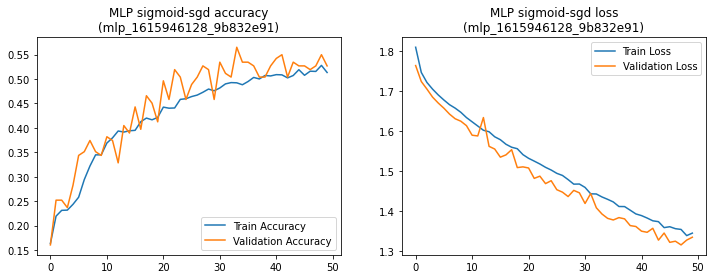

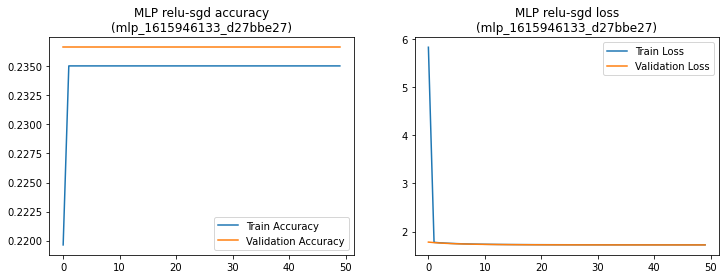

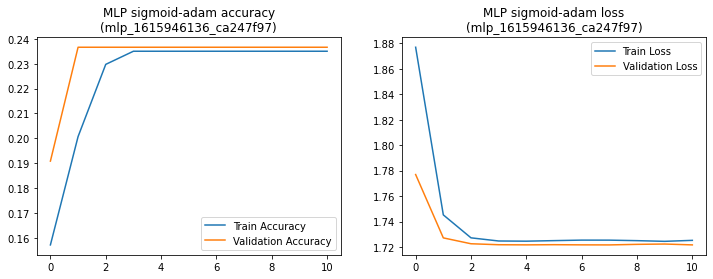

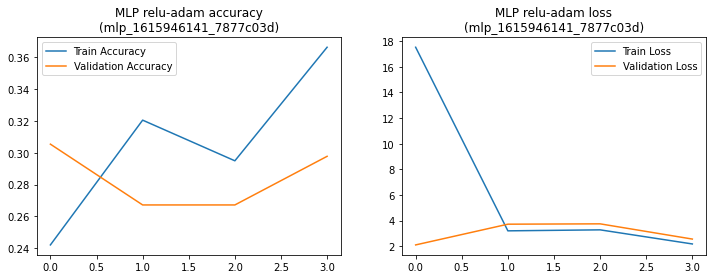

In [21]:
#Visualize the run accuracy
visualize_log(log)

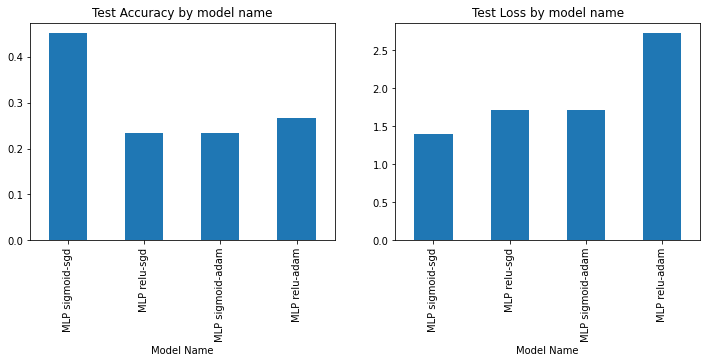

In [22]:
# compare the test accuracy
plot_accuracy(log)

## Comments
The best performing model so far is the model that uses the sigmoid activation function and the sgd optimizer.  The other models didn't converge well.

The model with the relu activation function and the sgd optimizer ran for the full 50 epochs which likely means we were suffering from a disappearing gradient.  The validation_loss continued to improve but only incrementally and progressively less in each iteration.

We will continue testing keeping the sigmoid activation and sgd optimizer, now focusing on the size of the Dense layers.

# Test 2
## Model 5

Since sigmoid and sgd performed best we will keep those but try various sizes for the nodes in the hidden layers.
- hidden layer 1: Dense, 64 nodes, sigmoid activation function
- hidden layer 2: Dense, 32 nodes, sigmoid activation function
- optimizer: sgd

In [23]:
# Start with our best run for comparison
runs2 = []

In [24]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '64,32',
        '--activation', 'sigmoid,sigmoid',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [25]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'MLP 64-32'})

runs2[-1].tag('activation', 'sigmoid')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('hidden layers', '2')
runs2[-1].tag('layer sizes', '64,32')

## Model 6

- hidden layer 1: Dense, 128 nodes, sigmoid activation function
- hidden layer 2: Dense, 64 nodes, sigmoid activation function
- optimizer: sgd

In [26]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '128,64',
        '--activation', 'sigmoid,sigmoid',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [27]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'MLP 128-64'})

runs2[-1].tag('activation', 'sigmoid')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('hidden layers', '2')
runs2[-1].tag('layer sizes', '128,64')

## Model 7

- hidden layer 1: Dense, 256 nodes, sigmoid activation function
- hidden layer 2: Dense, 128 nodes, sigmoid activation function
- optimizer: sgd

In [28]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '256,128',
        '--activation', 'sigmoid,sigmoid',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [29]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'MLP 256-128'})

runs2[-1].tag('activation', 'sigmoid')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('hidden layers', '2')
runs2[-1].tag('layer sizes', '256,128')

## Model 8

- hidden layer 1: Dense, 512, nodes, sigmoid activation function
- hidden layer 2: Dense, 256, nodes, sigmoid activation function
- optimizer: sgd

In [30]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '512,256',
        '--activation', 'sigmoid,sigmoid',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [31]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'MLP 512-256'})

runs2[-1].tag('activation', 'sigmoid')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('hidden layers', '2')
runs2[-1].tag('layer sizes', '512,256')

## Start Tensorboard to monitor the runs

In [32]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs2)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [33]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

## Log and visualize

In [34]:
log = log_runs(runs2, 'mlp')
log

{'test_loss': 1.4736413955688477, 'test_accuracy': 0.4193548262119293}

{'test_loss': 1.3151240348815918, 'test_accuracy': 0.47580644488334656}

{'test_loss': 1.405181646347046, 'test_accuracy': 0.4354838728904724}

{'test_loss': 1.5481935739517212, 'test_accuracy': 0.4032258093357086}

,name,type,runtime,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
mlp_1615946128_9b832e91,MLP sigmoid-sgd,mlp,00:05:51.034539,1.400892,0.451613,"[1.810218095779419, 1.7473125457763672, 1.7222...","[0.16329225897789001, 0.21919013559818268, 0.2...","[1.7644546031951904, 1.7245925664901733, 1.705...","[0.16030533611774445, 0.25190839171409607, 0.2..."
mlp_1615946133_d27bbe27,MLP relu-sgd,mlp,00:06:27.447088,1.716499,0.233871,"[5.823765277862549, 1.775309681892395, 1.76627...","[0.21963028609752655, 0.23503521084785461, 0.2...","[1.7801183462142944, 1.7698891162872314, 1.761...","[0.23664122819900513, 0.23664122819900513, 0.2..."
mlp_1615946136_ca247f97,MLP sigmoid-adam,mlp,00:05:31.797260,1.716205,0.233871,"[1.8769735097885132, 1.7452263832092285, 1.727...","[0.15713028609752655, 0.20070423185825348, 0.2...","[1.7769371271133423, 1.7271627187728882, 1.722...","[0.19083969295024872, 0.23664122819900513, 0.2..."
mlp_1615946141_7877c03d,MLP relu-adam,mlp,00:04:03.232936,2.722870,0.266129,"[17.526952743530273, 3.205724000930786, 3.2831...","[0.24207746982574463, 0.32042253017425537, 0.2...","[2.1078169345855713, 3.724834442138672, 3.7517...","[0.30534350872039795, 0.2671755850315094, 0.26..."
mlp_1615947032_805fd21a,MLP 64-32,mlp,00:03:11.253342,1.473641,0.419355,"[1.767706274986267, 1.7204219102859497, 1.7032...","[0.2244718372821808, 0.23283450305461884, 0.23...","[1.727188229560852, 1.6985050439834595, 1.6823...","[0.23664122819900513, 0.23664122819900513, 0.2..."
mlp_1615947038_62e173f6,MLP 128-64,mlp,00:06:30.061616,1.315124,0.475806,"[1.7203178405761719, 1.6790343523025513, 1.651...","[0.23635563254356384, 0.26760563254356384, 0.3...","[1.6924328804016113, 1.6568700075149536, 1.602...","[0.23664122819900513, 0.2977099120616913, 0.37..."
mlp_1615947042_b01c5447,MLP 256-128,mlp,00:06:54.305487,1.405182,0.435484,"[1.7257249355316162, 1.6717264652252197, 1.624...","[0.2332746535539627, 0.28565141558647156, 0.34...","[1.6891381740570068, 1.6540107727050781, 1.568...","[0.3206106722354889, 0.3435114622116089, 0.503..."
mlp_1615947046_df95c541,MLP 512-256,mlp,00:08:32.223836,1.548194,0.403226,"[1.715225338935852, 1.6461771726608276, 1.5873...","[0.22887323796749115, 0.2957746386528015, 0.34...","[1.6542049646377563, 1.6300697326660156, 1.502...","[0.3358778655529022, 0.37404578924179077, 0.41..."


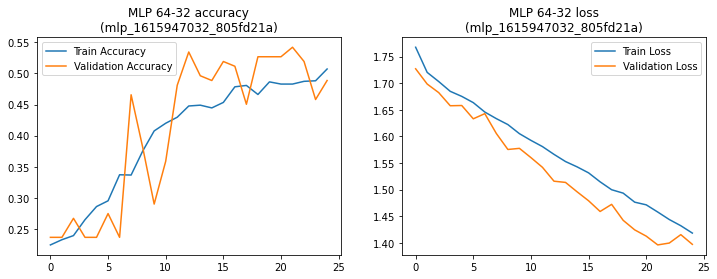

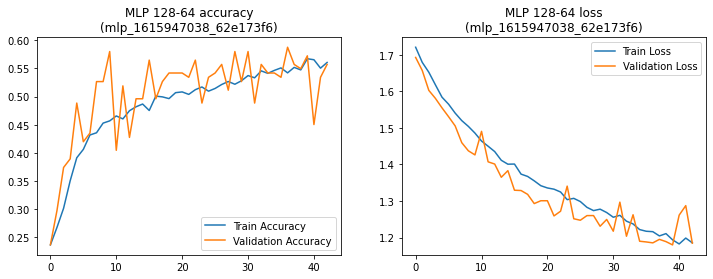

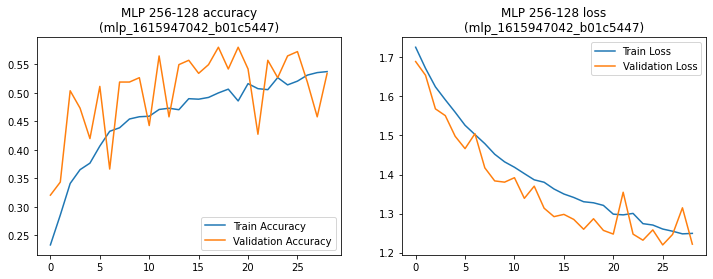

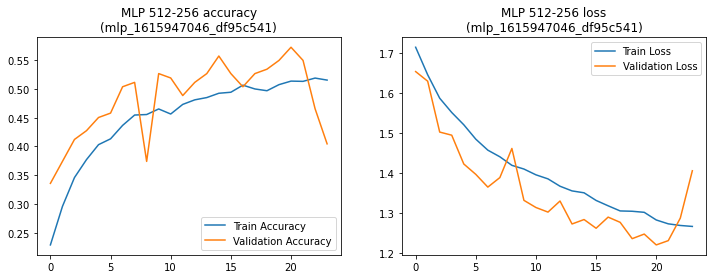

In [35]:
# visualize only run2
visualize_log(log.loc[[r.id for r in runs2]])

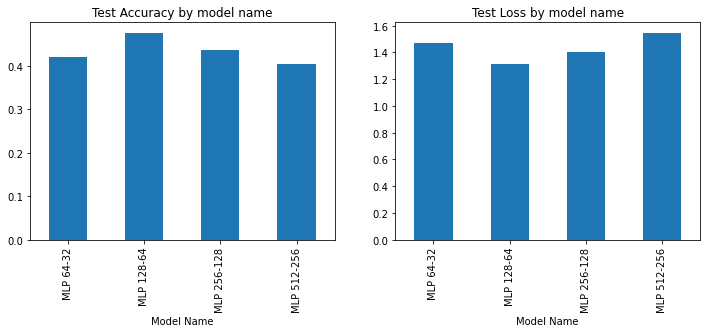

In [36]:
# compare test accuracy for run 2
plot_accuracy(log.loc[[r.id for r in runs2]])

## Comments

The model with 128/64 nodes in the Dense layers has the highest test accuracy and lowest test loss.  It also has the least erratic validation_loss over epochs.  Lets try adding an additional Dense layer to see how it performs.

# Test 3
## Model 9

Adding a layer to our best models so far.
- hidden layer 1: 128 nodes, sigmoid activation function
- hidden layer 2: 64 nodes, sigmoid activation function
- hidden layer 3: 32 nodes, sigmoid activation function
- optimizer: sgd

In [37]:
# start with the runs we want to compare to
runs3 = []

In [38]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '128,64,32',
        '--activation', 'sigmoid,sigmoid,sigmoid',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [39]:
runs3.append(exp.submit(config=src))

# Add name and tags for tracking
runs3[-1].add_properties({'name': 'MLP 128-64-32'})

runs3[-1].tag('activation', 'sigmoid')
runs3[-1].tag('optimizer', 'sgd')
runs3[-1].tag('hidden layers', '3')
runs3[-1].tag('layer sizes', '128,64,32')

## Start Tensorboard to monitor the runs

In [40]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs3)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [41]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

In [42]:
log = log_runs(runs3, 'mlp')

{'test_loss': 1.4740636348724365, 'test_accuracy': 0.4354838728904724}

In [43]:
log

,name,type,runtime,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
mlp_1615946128_9b832e91,MLP sigmoid-sgd,mlp,00:05:51.034539,1.400892,0.451613,"[1.810218095779419, 1.7473125457763672, 1.7222...","[0.16329225897789001, 0.21919013559818268, 0.2...","[1.7644546031951904, 1.7245925664901733, 1.705...","[0.16030533611774445, 0.25190839171409607, 0.2..."
mlp_1615946133_d27bbe27,MLP relu-sgd,mlp,00:06:27.447088,1.716499,0.233871,"[5.823765277862549, 1.775309681892395, 1.76627...","[0.21963028609752655, 0.23503521084785461, 0.2...","[1.7801183462142944, 1.7698891162872314, 1.761...","[0.23664122819900513, 0.23664122819900513, 0.2..."
mlp_1615946136_ca247f97,MLP sigmoid-adam,mlp,00:05:31.797260,1.716205,0.233871,"[1.8769735097885132, 1.7452263832092285, 1.727...","[0.15713028609752655, 0.20070423185825348, 0.2...","[1.7769371271133423, 1.7271627187728882, 1.722...","[0.19083969295024872, 0.23664122819900513, 0.2..."
mlp_1615946141_7877c03d,MLP relu-adam,mlp,00:04:03.232936,2.722870,0.266129,"[17.526952743530273, 3.205724000930786, 3.2831...","[0.24207746982574463, 0.32042253017425537, 0.2...","[2.1078169345855713, 3.724834442138672, 3.7517...","[0.30534350872039795, 0.2671755850315094, 0.26..."
mlp_1615947032_805fd21a,MLP 64-32,mlp,00:03:11.253342,1.473641,0.419355,"[1.767706274986267, 1.7204219102859497, 1.7032...","[0.2244718372821808, 0.23283450305461884, 0.23...","[1.727188229560852, 1.6985050439834595, 1.6823...","[0.23664122819900513, 0.23664122819900513, 0.2..."
mlp_1615947038_62e173f6,MLP 128-64,mlp,00:06:30.061616,1.315124,0.475806,"[1.7203178405761719, 1.6790343523025513, 1.651...","[0.23635563254356384, 0.26760563254356384, 0.3...","[1.6924328804016113, 1.6568700075149536, 1.602...","[0.23664122819900513, 0.2977099120616913, 0.37..."
mlp_1615947042_b01c5447,MLP 256-128,mlp,00:06:54.305487,1.405182,0.435484,"[1.7257249355316162, 1.6717264652252197, 1.624...","[0.2332746535539627, 0.28565141558647156, 0.34...","[1.6891381740570068, 1.6540107727050781, 1.568...","[0.3206106722354889, 0.3435114622116089, 0.503..."
mlp_1615947046_df95c541,MLP 512-256,mlp,00:08:32.223836,1.548194,0.403226,"[1.715225338935852, 1.6461771726608276, 1.5873...","[0.22887323796749115, 0.2957746386528015, 0.34...","[1.6542049646377563, 1.6300697326660156, 1.502...","[0.3358778655529022, 0.37404578924179077, 0.41..."
mlp_1615948136_f989d0c2,MLP 128-64-32,mlp,00:07:10.283817,1.474064,0.435484,"[1.7666215896606445, 1.7253185510635376, 1.716...","[0.23591549694538116, 0.23503521084785461, 0.2...","[1.7295371294021606, 1.7154314517974854, 1.709...","[0.23664122819900513, 0.23664122819900513, 0.2..."


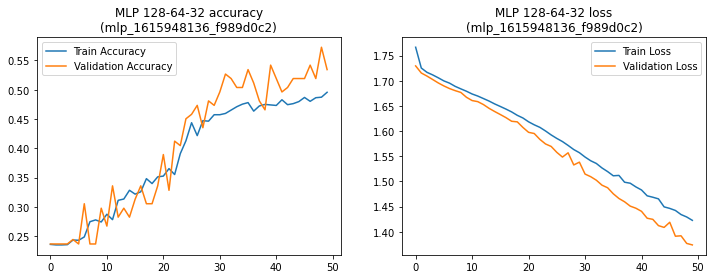

In [44]:
visualize_log(log.loc[[r.id for r in runs3]])

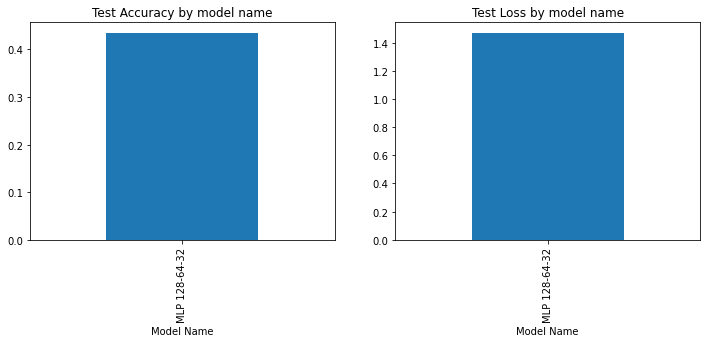

In [45]:
plot_accuracy(log.loc[[r.id for r in runs3]])

## Comments
Adding a layer to our best model decreased performance on the test set with similar validation accuracy and loss.  We may have exhausted the possibilities of MLPs.  Time to move on to [CNNs](3_Azure.ipynb)